In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
# alley, miscfeature, fence, fireplacequ , and poolqc are columns with missing data. Going to drop them.
df.drop(['alley','miscfeature','fence','fireplacequ', 'poolqc'], axis = 1, inplace = True)

In [7]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Gonna use heatmap to see the correlation between the columns

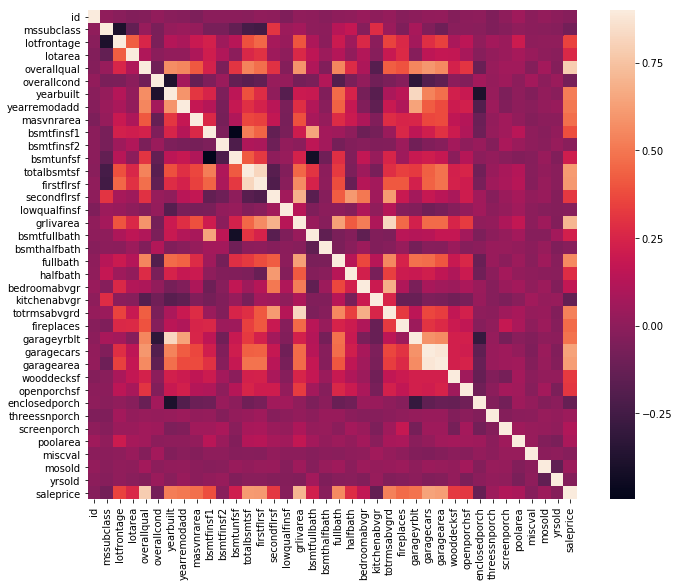

In [8]:
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

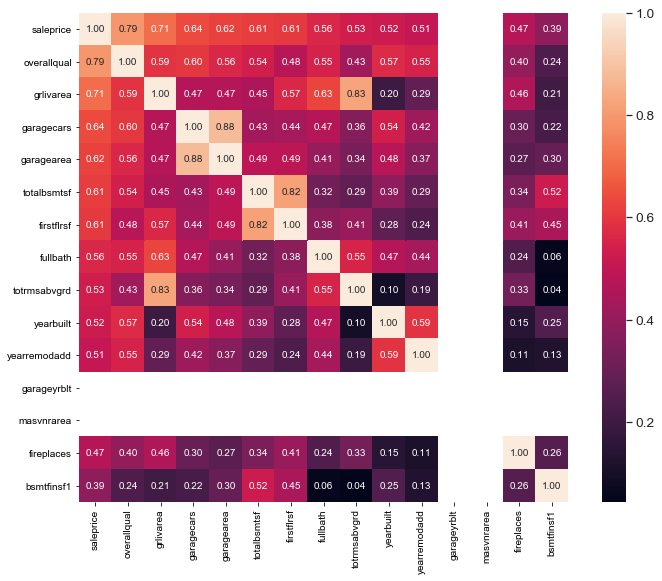

In [9]:
# Finding the top 15 columns that correlate the most with saleprice
k = 15
corrmat = df.corr()
cols = corrmat.nlargest(k, 'saleprice')['saleprice'].index
cm = np.corrcoef(df[cols].values.T)
plt.subplots(figsize=(12,9))

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [12]:
missing_values = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([missing_values, percent_missing], axis = 1, keys = ['Total','percent'])[:20]
missing.head(20)

,Total,percent
lotfrontage,259,0.177397
garagefinish,81,0.055479
garagetype,81,0.055479
garagecond,81,0.055479
garagequal,81,0.055479
garageyrblt,81,0.055479
bsmtexposure,38,0.026027
bsmtfintype2,38,0.026027
bsmtfintype1,37,0.025342
bsmtcond,37,0.025342


In [13]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood 
#due to skewed disrtribution
df['lotfrontage']= df.groupby('neighborhood')['lotfrontage'].transform(lambda x: x.fillna(x.median()))

In [14]:
for col in ('garagetype' , 'garagefinish', 'garagequal', 'garagecond'):
    df[col] = df[col].fillna('None')

In [15]:
df['garageyrblt'] = df['garageyrblt'].fillna('0')

In [16]:
for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
    df[col] = df[col].fillna('None')
    

df["masvnrtype"] = df["masvnrtype"].fillna("None")
df["masvnrarea"] = df["masvnrarea"].fillna(0)

In [17]:
# fill the missing value with the most common
df['electrical']=df['electrical'].fillna(df['electrical'].mode()[0])

In [21]:
missing=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing.head()

saleprice      0.0
extercond      0.0
roofstyle      0.0
roofmatl       0.0
exterior1st    0.0
dtype: float64

All columns have no nulls

Check for Outliers 

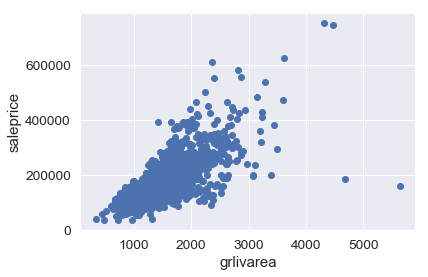

In [22]:
plt.scatter(df['grlivarea'],df['saleprice'])
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

In [23]:
#deleting points
df = df.drop(df[df['id']== 1299].index)
df = df.drop(df[df['id']==524].index)

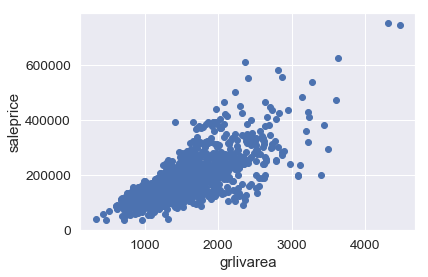

In [24]:
plt.scatter(df['grlivarea'],df['saleprice'])
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

In [25]:
# Adding total sqfootage feature i think it's best to combine all all together to avoid overfitting. 
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

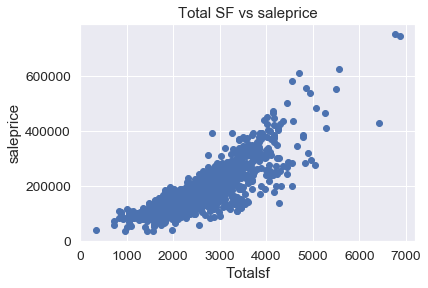

In [26]:

plt.scatter(df['totalsf'],df['saleprice'])
plt.title('Total SF vs saleprice')
plt.xlabel('Totalsf')
plt.ylabel('saleprice')
plt.show()

Normalizing the variables

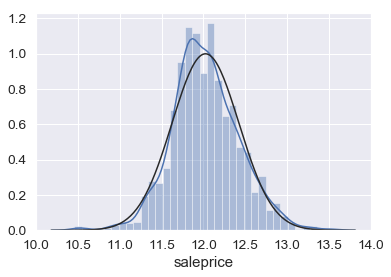

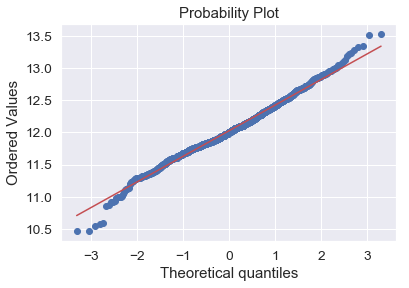

In [27]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["saleprice"] = np.log1p(df["saleprice"])

#Check the new distribution 
sns.distplot(df['saleprice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['saleprice'], plot=plt)
plt.show()

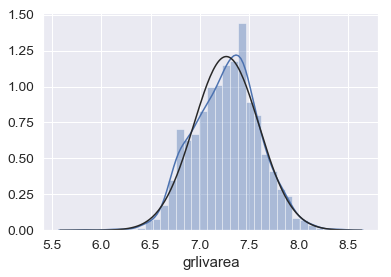

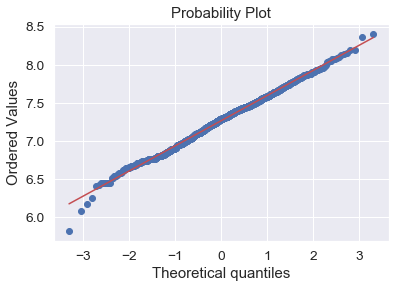

In [28]:
#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["grlivarea"] = np.log1p(df["grlivarea"])

#Check the new distribution 
sns.distplot(df['grlivarea'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['grlivarea'], plot=plt)
plt.show()

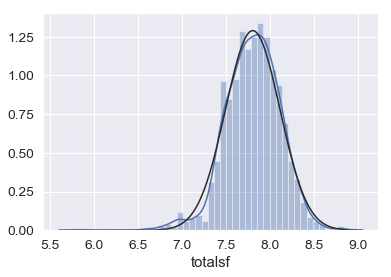

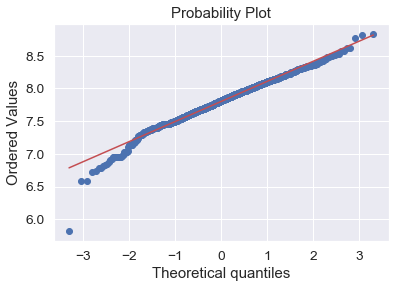

In [29]:
#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["totalsf"] = np.log1p(df["totalsf"])

#Check the new distribution 
sns.distplot(df['totalsf'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['totalsf'], plot=plt)
plt.show()

Found an average  30 year mortage rate from 1971 to 2019

In [52]:
rate = pd.read_csv("MORTGAGE30US.csv")

In [53]:
rate.head()

,date,MORTGAGE30US
0,1971,7.54
1,1972,7.38
2,1973,8.04
3,1974,9.19
4,1975,9.05


In [54]:
rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 2 columns):
date            49 non-null int64
MORTGAGE30US    49 non-null float64
dtypes: float64(1), int64(1)
memory usage: 864.0 bytes


In [55]:
df['date']= df['yrsold'].astype(int)

In [56]:
df_new = df['date']

In [58]:
df_1 = pd.merge(df_new, rate, on='date')

In [59]:
df = pd.merge(df, df_1)

In [60]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,totalsf,date,MORTGAGE30US
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.03
1,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.03
2,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.03
3,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.03
4,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.03


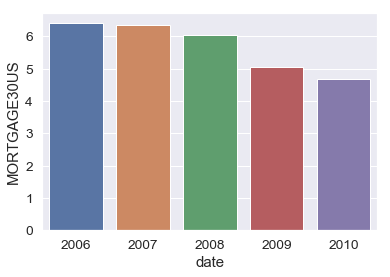

In [61]:
sns.barplot(x = df['date'],y =  df['MORTGAGE30US'])
plt.show()

In [66]:
corr= df.corr()['saleprice']
corr.sort_values(ascending=False)

saleprice        1.000000
overallqual      0.822198
totalsf          0.816756
grlivarea        0.738148
garagecars       0.681714
garagearea       0.656856
totalbsmtsf      0.645476
firstflrsf       0.619496
fullbath         0.598749
yearbuilt        0.585951
yearremodadd     0.567816
totrmsabvgrd     0.537680
fireplaces       0.493072
masvnrarea       0.429549
bsmtfinsf1       0.386145
lotfrontage      0.373857
wooddecksf       0.339741
openporchsf      0.324246
secondflrsf      0.321867
halfbath         0.313397
lotarea          0.258071
bsmtfullbath     0.239180
bsmtunfsf        0.224241
bedroomabvgr     0.211196
screenporch      0.124051
poolarea         0.076980
mosold           0.059012
threessnporch    0.052868
MORTGAGE30US     0.036502
bsmtfinsf2       0.011232
bsmthalfbath    -0.004051
miscval         -0.016681
id              -0.022290
overallcond     -0.035838
date            -0.035858
yrsold          -0.035858
lowqualfinsf    -0.039052
mssubclass      -0.067557
kitchenabvgr

30 year mortage showed it has a low correlation for Sale prices with 0.0365

In [75]:
df = pd.concat([df,pd.get_dummies(df.kitchenqual, prefix="kitchenqual")], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street")], axis=1)
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning",drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df.MORTGAGE30US, prefix='MORTGAGE30US')], axis = 1)

dummy = list(pd.get_dummies(df.kitchenqual, prefix="kitchenqual").columns)
dummy = dummy + list(pd.get_dummies(df.street, prefix="street").columns)
dummy = dummy + list(pd.get_dummies(df.mszoning, prefix="mszoning",drop_first = True).columns)
dummy = dummy + list(pd.get_dummies(df.MORTGAGE30US, prefix = 'MORTGAGE30US').columns)

In [76]:
X = df[['overallqual','totalsf','garagecars','grlivarea', 'lotfrontage']+dummy]
Y = np.log1p(df['saleprice'])

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 7)

In [78]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8630149879091336
-----Test set statistics-----
R-squared of the model in test set is: 0.8613793674766588
Mean absolute error of the prediction is: 0.008389763615448896
Mean squared error of the prediction is: 0.0001303729795531487
Root mean squared error of the prediction is: 0.011418098771386973
Mean absolute percentage error of the prediction is: 0.32771658185166647


In [79]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lrm, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.8629815484924754
Accuracy: 0.86 (+/- 0.00)


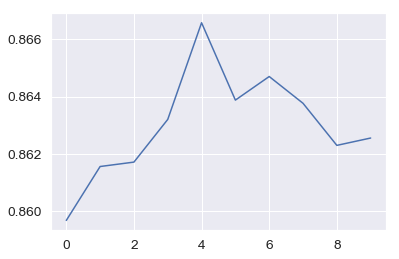

[0.85967133 0.86155502 0.86170925 0.86320106 0.86657947 0.86387597
 0.86470002 0.86376465 0.8622939  0.86255075]


In [81]:
scores = cross_val_score(lrm, X_train, y_train, cv=10)
plt.plot(scores)
plt.show()
print(scores)

No over-fitting in the model

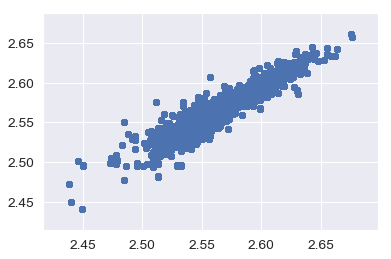

In [83]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(lrm, X_train, y_train, cv=5)
plt.scatter(y_train,y_pred)

In [85]:
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(cv =5)

ridge_cv.fit(X_train,y_train)
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.1
R-squared of the model in training set is: 0.86301498786723
-----Test set statistics-----
R-squared of the model in test set is: 0.8613794108329247
Mean absolute error of the prediction is: 0.008389765555333162
Mean squared error of the prediction is: 0.00013037293877649474
Root mean squared error of the prediction is: 0.011418096985771961
Mean absolute percentage error of the prediction is: 0.32771666091787455


In [86]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ridge_cv, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.862980138034009
Accuracy: 0.86 (+/- 0.00)


In [87]:
lasso_cv = LassoCV(cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.00024567221774741396
R-squared of the model in training set is: 0.8466956625732568
-----Test set statistics-----
R-squared of the model in test set is: 0.8455993193064221
Mean absolute error of the prediction is: 0.008746203919126404
Mean squared error of the prediction is: 0.00014521414612407428
Root mean squared error of the prediction is: 0.012050483231973491
Mean absolute percentage error of the prediction is: 0.3416601501949878


In [88]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lasso_cv, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.8466713082549941
Accuracy: 0.85 (+/- 0.00)


In [89]:
elasticnet_cv = ElasticNetCV(cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0004913444354948279
R-squared of the model in training set is: 0.846653811817426
-----Test set statistics-----
R-squared of the model in test set is: 0.8455554490689813
Mean absolute error of the prediction is: 0.008747970327992651
Mean squared error of the prediction is: 0.00014525540616931262
Root mean squared error of the prediction is: 0.012052195076802923
Mean absolute percentage error of the prediction is: 0.34172758544622556


Lrm and Ridgecv are the best models based on High R-Squared and accuracy